## Predictive Analysis of Movie ImdbRating Score

## Introduction

People love to watch movies, and tend to be selective on the movies at the same time. The movie review websites, such as IMDB, Rotten Tomatoes, and Metacritics, have provided people hints of which movie is worth spending money and time for. However, unlike some movies already released and can be watched online, some movies have not been on big screen yet, and the rating scores of them are unavailable. Therefore it is hard for people to decide if they should go watch it or not. Such a need inspires us to research on how to predict a movie's rating score before it released publicly. We have collected data from [The Numbers](http://www.the-numbers.com/movie/budgets/all) and [OMDB API](http://www.omdbapi.com). After muging the data, we have done some descriptive analysis on the data through data visualization. Then we perform Mutiple Linear Regression and Random Forest on the data to build the predictive model for the movie data. At last, we have found out that generally Metascore(if available), Director, Actor, Runtime, Specific Genres, Rated, and Year had been influential to the IMDb rating score. 

## Data Collecting

Gathering movie data is a bit tricky, since most of the movie rating websites do not provide a public API for people to use, and it is hard to find a list of all movies in the history. To solve this problem, we have first gotten a list of more than 5000 movies from the website named [The Numbers](http://www.the-numbers.com/movie/budgets/all) which contains the titles, budget, and released year of the movies. Then we search the titles with the year(some of the movies share the same name so the year can distinguish them) in [OMDB API](http://www.omdbapi.com), which is a free web service to provide API access for people to obtain movie information. We have gotten most of the basic information of movies from this database, including Director, main actor and actress, country, genre, metascore, rate, runtime, year, imdbID, imdbRating, and imdbVotes. 

In [63]:
import requests
import requests_cache
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
requests_cache.install_cache('coll_cache')
def fetch_page(url):
    response = requests.get(url)
    response.raise_for_status()
    return response

Scraping data from the numbers website. Also we made budget a separate list since we will concat it to our movie dataframe for further usage.

In [2]:
import lxml.html as lx
url="http://www.the-numbers.com/movie/budgets/all"
page = fetch_page(url)
html = lx.fromstring(page.text)
ti = html.xpath("//td/b/a")
title=[x.text_content() for x in ti]
bu = html.xpath("//td[@class = 'data']")
bud=[x.text_content() for x in bu]
#Since there are several types of budget and gross income get scraped by the xpath, I have made a loop to extract 
#the budget we want.
budget=[]
for i in range(0,len(bud)):
    if i%4==1:
        budget.append(bud[i])
ye=html.xpath("//td/a")
year=[x.text_content() for x in ye]
year=[x[-4:] for x in year]
moviebudget = pd.DataFrame(
    {'Budget': budget
    })

Here I have defined a function for accessing API of OMDB to get movie data.

In [3]:
def movie_search(title,year):
    '''
    This is a public api so no key is needed, and I have inputted 
    the title and year we have gotten from the number website.
    '''
    url="http://www.omdbapi.com/?"
    response=requests.get(url,params={
        "t":title,
        "r":"json",
        "y":year
    })
    response.raise_for_status()
    result=response.json()
    return result

Search for all the titles in OMDB and get the result data.

In [ ]:
data=[]
for i in range(0,len(title)):
    data.append(movie_search(title[i],year[i]))
data=pd.DataFrame(data)   

## Data Munging

Since gathering data takes a huge amount of time, after first obtaining it, we store it in a csv file, and just read the data from it in further studies.

In [4]:
data1=pd.read_csv('movies.csv')
#concat the movie budget data to the main dataframe first.
data1 = pd.concat([data1,moviebudget], axis=1)


In [5]:
#There are a lot of NAs in the data, so we have eliminated the data which dont have an imdbRating score, a run time, or a country.
data2=data1.dropna(subset=['imdbRating','Runtime','Country'])
#Some of the data are from TV series, so we have limited it to only movie.
data2=data2[data1.Type=='movie']
#need to convert the datatypes of several variables for further string manipulation.
data2[['Genre', 'Rated']] =data2[['Genre', 'Rated']].astype(str) 

Here we have made our choices of features according to our common sense. We have chosen to not to include the imdbVotes and Award variable, although it may have a significant correlation with the IMDb score. Since our primary goal is to predict a movie's rating score, and the movie is unlikely to be viewed by a large amount of people or sent to consider for Academy Award yet, therefore the imdbvotes and Award data for movies being predicted will not be accurate and completed when we perform the prediction. Including these 2 variables is not reasonable and will only cause overfitting.

In [6]:
#in the data3, we have selected the columns which we need and do not require any transformation.
data3=data2[['Country','Metascore','Year','imdbRating','Budget','Director']]
data3.index=range(0,len(data3))

Since runtimes are stated in the format like 100 min, so we have eliminate the min part and make them intergers.

In [7]:
a=[]
for i in data2.Runtime:
    a.append(i.split(" ")[0])
time=pd.DataFrame(a)
time.columns=["Runtime"]

In my opinion, genre is pretty significant for predicting the movie ratings, since some of the genres tend to have higher rating scores than other genres do. However, it is also pretty tricky to deal with the genre since a large amount of movies belong to more than 1 genre. Therefore I have decided to create a lot of binary variables to indicate if the movie belongs to this genre or not. 

In [8]:
import re
genres=data2.Genre.tolist()
#I have combined Sci-Fi and Fantasy since these 2 genres are pretty similar.
genres = [re.sub("Sci-Fi","Fantasy",i) for i in genres]
def match(keyword1,attribute):
    '''
    Since there are a lot of genres for which we need to create dummy variables
    Through this function, we can just enter the name of the genre   
    and the function will return a list as the dummy variable
    '''
    a=[]
    for i in attribute:
        if re.search(keyword1,i):
            a.append(1)
        else:
            a.append(0)
    return a

In [9]:
gen=["Action","Animation","Adventure","Drama","Comedy","Documentary","Mystery","Biography","Crime","Fantasy","Horror","Romance"]
g=[]
for i in gen:
    g.append(match(i,genres))
genlist=pd.DataFrame(g).transpose()
genlist.columns=gen

Rating decides the age group of the audience of the movie, so it may also have some influence on the rating scores too. We have used the same strategy as how we process the genre for the rating.

In [10]:
Rated=data2.Rated.tolist()
#Since PG 13 and PG will be both matched when we match PG, I have changed PG13 to P13.
Rated = [re.sub("PG-13","P13",i) for i in Rated]
rating=["PG","P13","R"]
rates=[]
for i in rating:
    rates.append(match(i,Rated))
ratelist=pd.DataFrame(rates).transpose()
ratelist.columns=rating

In the original data, the actors variable is a long object with at most 3 actor or actress names connected by ",", so I have transform and split it into the 3 variables which represent the top 3 actors and actress in this movie.

In [11]:
actor=[]
data2[['Actors']] = data2[['Actors']].astype(str)
for i in range(0,len(data2)):
    a=data2['Actors'].iloc[i].split(", ")
    if len(a)==1:
        actor.append([a[0],"NA","NA"])
    elif len(a)==2:
        actor.append([a[0],a[1],"NA"])
    elif len(a)>2:
        actor.append([a[0],a[1],a[2]]) 
    else:
        actor.append(["NA","NA","NA"]) 

In [12]:
actorlist=pd.DataFrame(actor)
actorlist.columns=["actor1","actor2","actor3"]

In [14]:
#Combine the transformed data we have together.
result = pd.concat([data3, time,genlist,actorlist,ratelist], axis=1)

We are trying to find a way to quantify the effect of actors, actress, and directors on the rating score of a movie. At first, I was hoping to use the average movie rating score of them as my explanatory variables. However, it turned out that most of them only appeared once in the list, and if I used the average score, there would definitely be overfitting. Therefore, I decided to find a list of good actors and directors, and see how many good actors are in that movie, and if the director is one of the top 250 directors in the history, since I think normally when several good actors are in the same movie, that movie will be at least not bad. 

In [15]:
topactors = pd.read_csv('Top 1000 Actors and Actresses.csv')
#here we have added a column with value 1 to the data frame, and we will use it as the indicator of 
#the existence of a actor or an actress listed in the top 1000, and at last we add them together to get the score.
topactors["a"]=1
topactors=topactors.drop_duplicates()
result1=result.merge(topactors, left_on='actor1', right_on='Name', how='left')
result2=result1.merge(topactors, left_on='actor2', right_on='Name', how='left')
result3=result2.merge(topactors, left_on='actor3', right_on='Name', how='left')

In [16]:
#the a_x a_y and a represent the score for the actors, if the actor is in top 1000, they will be scored 1
#For the NAs which means that actors are not in the list, we fill them with 0
result3[['a_x','a_y','a']]=result3[['a_x','a_y','a']].fillna(0)
#Add the score together
result3['actorscore']=result3.a_x+result3.a_y+result3.a
#Drop the irrelevant variables.
result3.drop(['a','Name','a_y','Name_y','a_x','Name_x'],inplace=True,axis=1)

In [17]:
#Same way as manipulating the actors.
topdirectors = pd.read_csv('Top 250 directors by IMDB rating.csv')
topdirectors["Directorscore"]=1
topdirectors=topdirectors.drop_duplicates()
result4=result3.merge(topdirectors, left_on='Director', right_on='Name', how='left')
result4[["Directorscore"]]=result4[["Directorscore"]].fillna(0)
result4.drop(['Name'],inplace=True,axis=1)

In [18]:
#Convert their datatype to numeric for further usage.
result4[['Year','imdbRating','Runtime']] = result4[['Year','imdbRating','Runtime']].apply(pd.to_numeric)

In [19]:
#elliminate some movies which are weigh too short.
Final=result4[result4.Runtime>60]

In [20]:
#Since the Budget number comes with a dollar sign and "," between numbers, we need to convert them to numeric format.
Final['Budget'] = Final['Budget'].str.replace('$', '')
Final['Budget'] = Final['Budget'].str.replace(',', '')
Final['Budget'] = Final['Budget'].astype(int)
#Since the budget is huge for a lot of movies, we have divided it by 1,000,000 to measure it in million.
Final['Budget'] = Final['Budget']/1000000

## Descriptive Analysis Through Data Visualization

In [21]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size']=14


__Overall Distribution of Movie Rating Score__

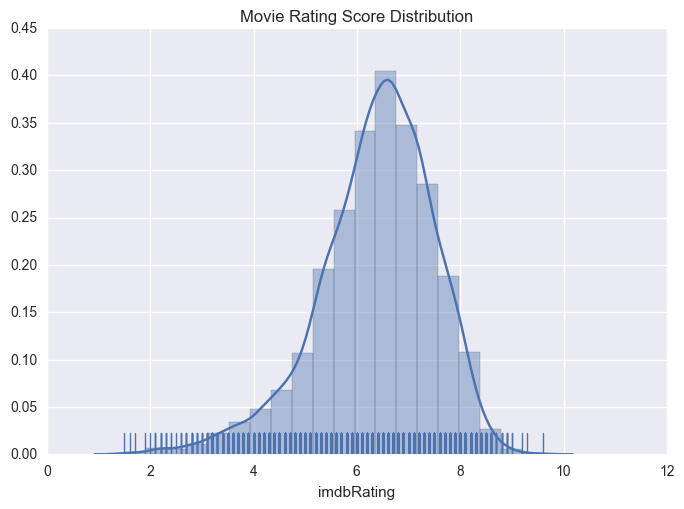

In [23]:
import seaborn as sns
sns.set(color_codes=True)
sns_plot=sns.distplot(Final['imdbRating'], bins=20, kde=True, rug=True)
fig = sns_plot.get_figure()
fig.savefig("Distribution of Movie Rating Scores.png") 
sns.plt.title('Movie Rating Score Distribution')
sns.plt.show()

Most of the movie rating scores fall in the 6-7 interval, a little number of the movie rating scores are extreme like 1,2 or 9.

__Scatter Plot on Budget and Movie Produced Year__

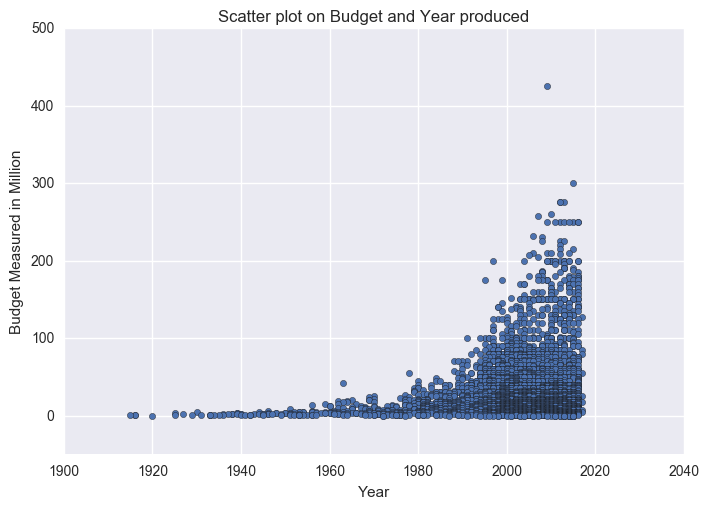

In [25]:
plt.xlabel('Year')
plt.ylabel('Budget Measured in Million')
plt.ylim(-50,500)
plt.scatter(Final['Year'],Final['Budget'])
plt.title('Scatter plot on Budget and Year produced')
plt.show()


This plot is drawed to see the relationship between the produced year and the movie budget, and through the degree of intensiveness of the dots in the plot, we can also get a hint about the distribution of the number of movies produced each year. The result is in accordance with common sense, as the time goes forward, more and more budget are spent on the movies. Also, the number of movies being produced gradually increases through the time.

__Choropleth Map on Average Movie Rating Score and Number of Movies Being produced on the Country Level__

The tricky part of dealing with country data is that most of the movies are not just produced by one country. Therefore I need to do some pre-processing to decompose the data into a new form. For example, if a movie is produced by US and China and rated 7, then the new data will include 2 rows of this movie, the first one is US,7 and the second one is China, 7.

In [26]:
Final.index=range(0,len(Final))
Final['id']=Final.index
country=[]
for i in range(0,len(Final)):
    a=Final['Country'].iloc[i].encode('ascii','ignore').split(", ")
    country.append(a)  
c=[]
for i in range(0,len(country)):
    for j in country[i]:
        c.append([i,j])

In [27]:
cdata=pd.DataFrame(c)
cdata.columns=['id','country']
countrydata=cdata.merge(Final[["id","imdbRating"]], left_on='id', right_on='id', how='left')
#When I inspect data, I have found that several of the countries do not exist anymore, such as Soviet Union and West Germany.
#I have changed West Germany to Germany for further usage.
countrydata['country']=countrydata['country'].replace('West Germany', 'Germany')
#compute the average rating scores and number of movies for each country. 
sumcountry=countrydata.groupby('country').agg({'imdbRating': [np.size, np.mean]})

In [28]:
sumcountry['country']=sumcountry.index
sumcountry.columns=['number of movies','average rating score','country']

In [29]:
#Here I have found the country codes to use in the plotly to plot choropleth maps.
code = pd.read_csv('code.csv')
#I have merged the 2 dataframes to get the country code we need for choropleth maps.
df=sumcountry.merge(code[["CODE","COUNTRY"]], left_on='country', right_on='COUNTRY', how='left')

In [74]:
import plotly.plotly as py
import matplotlib.pyplot as plt
import plotly.offline as offline

offline.init_notebook_mode()
data = [ dict(
        type = 'choropleth',
        locations = df['CODE'],
        z = df['average rating score'],
        text = df['country'],
        autocolorscale = True,
        reversescale = False,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Average Movie Rating Score'),
      ) ]

layout = dict(
    title = 'IMDb Rating Score Distribution by Countries',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.image.save_as(fig, filename='Score Distribution.png')


Since the interactive plotly plot cannot be displayed correctly on github, we have to save a png file of it and then display it on notebook on github. However in this way, we lost the interactivity of the plot. All my conclusion on the plot is drawn from the interactive plot, though.

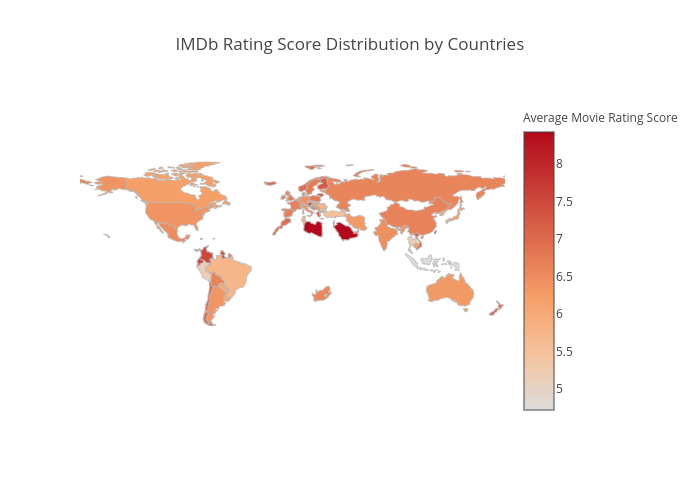

In [75]:
from IPython.display import Image
Image(filename='Score Distribution.png') 

Through this interactive plot, we can find out that most of the countries in the world have similar average movie rating scores around 6.5. A little number of countries have relatively higher or lower average scores, such as Libya, Columbia, and Guyana. Since these countries are relatively small countries and not known for producing movies, I think it is necessary to see the number of movies being produced by each country to avoid possible overfitting problems since these countries may have only 1 movie which scores higher and get recorded, and such results will not be beneficial to our predication analysis.

In [73]:
data1 = [ dict(
        type = 'choropleth',
        locations = df['CODE'],
        z = df['number of movies'],
        text = df['country'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            title = 'Average Movie Rating Score'),
      ) ]

layout1 = dict(
    title = 'Number of Movies Distribution by Countries',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig1 = dict( data=data1, layout=layout1 )
py.image.save_as(fig1, filename='Number of Movies Distribution.png')
#offline.iplot( fig1, validate=False, filename='d3-world-map1' )



Since the interactive plotly plot cannot be displayed correctly on github, we have to save a png file of it and then display it on notebook on github. However in this way, we lost the interactivity of the plot. All my conclusion on the plot is drawn from the interactive plot, though.

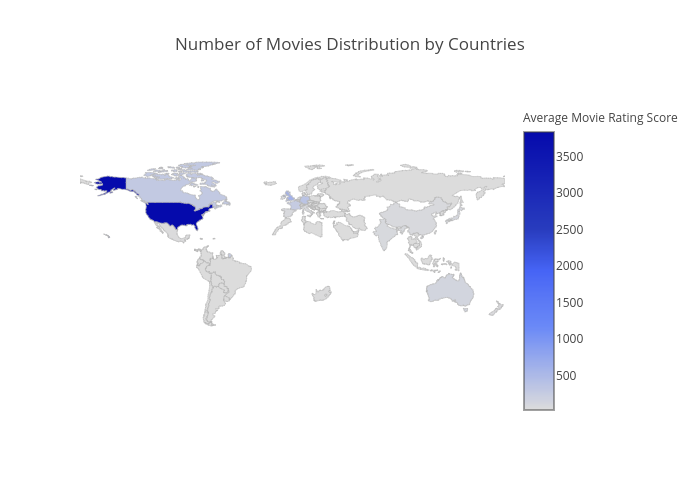

In [70]:
from IPython.display import Image
Image(filename='Number of Movies Distribution.png') 

The plot which reflects the number of movies being produced has explained our question from last plot. It is obvious that a huge amount of movies are from America, and larger countries such as UK, Canada, France, and Germany also get some movies, but the number is a lot smaller than that of American movie. For the countries which have relatively higher or lower rating scores, we have found out that there is only 1 movie recorded for each of them. Therefore, given that most countries have really similar average rating scores and there are only 1 movie record for the extreme score, we think that taking the country into count is not beneficial to the prediction. 

__The Distribution of Movie Rating Score by Genres__

In [32]:
boxdata=[]
for i in gen:
    a=[X['imdbRating'] for deg,X in Final.groupby(i)][1]
    boxdata.append(a)
boxdata=pd.DataFrame(boxdata).transpose()
boxdata.columns=gen

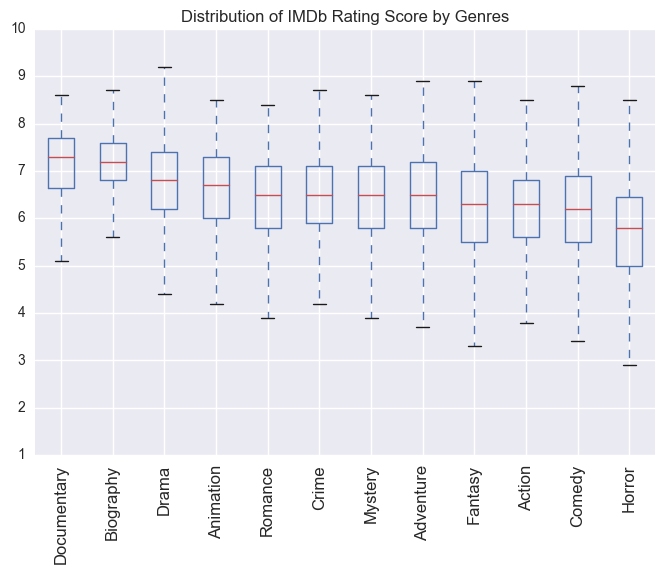

In [33]:
grouped = boxdata.groupby(gen)
meds = boxdata.median()
meds.sort(ascending=False)
boxdata = boxdata[meds.index]
boxdata.boxplot()
plt.xticks(rotation=90)
plt.title("Distribution of IMDb Rating Score by Genres")
plt.show()

From the plot, we can observe that there are differences among the genres. We have arranged them from the genre which have higher median rating score to those with lower median rating score. Documentary and Biography perform better among all the genres, and the rating scores of Horror and Comedy movies are relatively unsatisfactory.

__The Distribution of Movie Rating Score by Director Score and Actor Score__

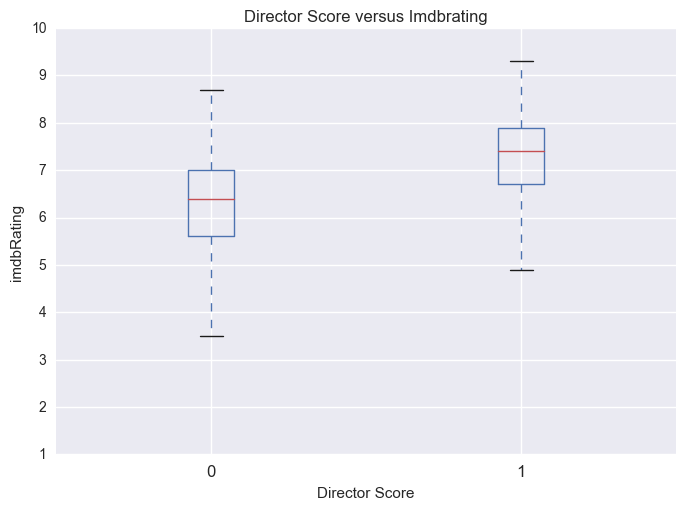

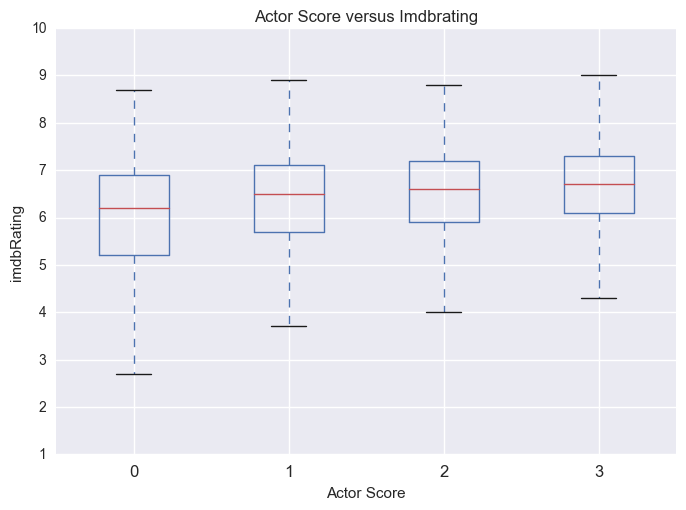

In [34]:
plt.figure(1)
dscore = [data["imdbRating"].dropna() for deg, data in Final.groupby("Directorscore")]
dscore=pd.DataFrame(dscore).transpose()
dscore.columns=['0','1']
dscore.boxplot()
plt.xlabel('Director Score')
plt.ylabel('imdbRating')
plt.title('Director Score versus Imdbrating')
plt.show()

plt.figure(2)
ascore = [data["imdbRating"].dropna() for deg, data in Final.groupby("actorscore")]
ascore=pd.DataFrame(ascore).transpose()
ascore.columns=['0','1','2','3']
ascore.boxplot()
plt.xlabel('Actor Score')
plt.ylabel('imdbRating')
plt.title('Actor Score versus Imdbrating')
plt.show()

Through ploting the Director Score vs ImdbRating and Actor Score vs ImdbRating, we can observe Directors and Actors do bring some influnence on the rating scores of a movie. Directors enlisted in Top250 Directors have a much higher median rating score than the ones who are not enlisted do. Also, the more main actors or actress included in the top 1000 actors and actress list for a movie, the higher rating score it tend to earn.

# Predictive Modelling

For the modelling part, we have decided to apply both Mutiple Linear Regression and Random Forest on our data, since we think both methods have their pros and cons, and we can take advantages from both of them to produce better results for our report. MLR is able to provide us a explainable model, so we have used MLR to see which factor influences the Imdb Rating score significantly, and how they influence the score. Random Forest is more like a black box, and we cannot interpret it like what we do to the MLR model. However, it generally performs better in explaining the variances of the data and building a predictive model. In a word, we have used MLR to see the influence of factors on the rating score, and suggested to use random forest to predict a movie's rating score.

Also, we have been discussing on if we should include Metascore in this model, and finally we think it all depends. Metascore is definitely a strong predictor for IMDb rating score since they all assess the quality of movies. However, for the movies which will screen in several months, Metascore may not be available. We have decided to derive 2 sets of models, one set of model for movies whose Metascores are available, and the other set are for movies whose Metascore are unavailable. Therefore we can predict rating scores of all the movies.

In [35]:
#Here I have presented all the variables we are likely to include in our model.
Final=Final[['imdbRating','Metascore', 'Year', 'Budget', 'Runtime', 
            'Action','Animation','Adventure','Drama','Comedy','Documentary','Mystery','Crime',
            'Biography','Fantasy','Horror','Romance','actorscore','Directorscore','R','PG','P13']]
#This is the data set we use to predict movies whose metascores are available.
MFinal=Final.loc[Final['Metascore'] >= 0]
MFinal.index=range(0,len(MFinal))
#This is the data set we use to predict movies whose metascores are unavailable.
NFinal=Final.drop('Metascore', 1)

__MLR for movies with Metascore__

In [36]:
from __future__ import print_function
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

Here we have drawed a correlation plot for all the variables to both have a look on the correlations between variables and see if there is possible multicolinearity presented. 

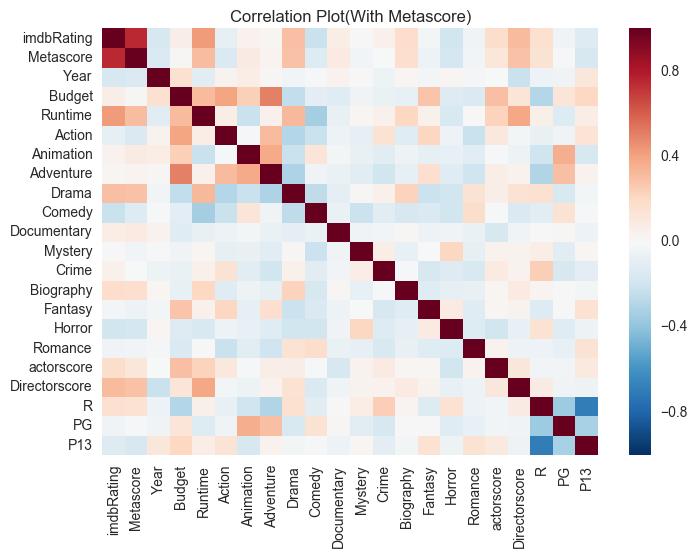

In [37]:
corr=MFinal.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
sns.plt.title('Correlation Plot(With Metascore)')
sns.plt.show()

It is apparent that Metascore has a strong correlation with the IMDb score as we have expected. Besides Metascore, we can see that Runtime, Drama, and Director score all have observable correlation with the Metascore. Among the independent varibles, there are not much strong correlations which will cause collinearity. Budget has some positive correlations with some genres such as Action, Animation, and Adventure, since movies belonged to these genres tend to spend more money. Also there are significant negative correlation between R, PG, and PG13 since they are mutually exclusive which are common for the dummy variables derived from categorical variables.

We have found an algorithm which applies Forward Selection to choose the best linear model we can have from the data. The criteria of this selection is the adjusted R square, since the general R square will always increase when we add in new variables.

In [38]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {}".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {}".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [39]:
Mmodel = forward_selected(MFinal, 'imdbRating')

In [40]:
Mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             imdbRating   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.629
Method:                 Least Squares   F-statistic:                     307.9
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        18:47:05   Log-Likelihood:                -3188.6
No. Observations:                3258   AIC:                             6415.
Df Residuals:                    3239   BIC:                             6531.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        16.9007      2.970      5.691      0.000        11.078    22.723
Metascore         0.0368      0.001     50.623      0.000         0.035     0.038
Runtime           0.0092      0.001     12.085      0.000         0.008     0.011
Comedy           -0.1500      0.030     -4.986      0.000        -0.209    -0.091
Horror           -0.2007      0.046     -4.325      0.000        -0.292    -0.110
R                 0.3511      0.072      4.894      0.000         0.210     0.492
actorscore        0.0506      0.011      4.416      0.000         0.028     0.073
Animation         0.3757      0.060      6.280      0.000         0.258     0.493
Year             -0.0069      0.001     -4.654      0.000        -0.010    -0.004
Documentary       0.3940      0.090      4.399      0.000         0.218     0.570
Drama             0.0671      0.030      2.240      0.025         0.008     0.126
Directorscore     0.0793      0.038      2.084      0.037         0.005     0.154
P13               0.2487      0.072      3.438      0.001         0.107     0.391
PG                0.1909      0.072      2.669      0.008         0.051     0.331
Mystery           0.0719      0.044      1.650      0.099        -0.014     0.157
Biography         0.0921      0.047      1.959      0.050     -6.11e-05     0.184
Fantasy           0.0798      0.034      2.319      0.020         0.012     0.147
Crime             0.0588      0.032      1.821      0.069        -0.005     0.122
Action           -0.0391      0.032     -1.224      0.221        -0.102     0.024
==============================================================================
Omnibus:                      378.028   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1049.793
Skew:                          -0.631   Prob(JB):                    1.10e-228
Kurtosis:                       5.478   Cond. No.                     5.27e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We are able to interpret the model through the summary of the model. All the interpretations below are based on the assumption that other variables stay __the same__.

For every 1 point increase of Metascore, IMDb rating score will increase 0.0368 point.

For every 1 minute increase of Runtime, IMDb rating score will increase 0.0092 point.

For every 1 year increase of Produced year, IMDb rating score will decrease 0.0069 point.

For every 1 more actor who is listed in top 1000 actors, IMDb rating score will increase 0.0506 point.

The movies directed by directors listed in the TOP250 directors tend to score 0.0793 higher than those don't.

Comedy movie tend to score 0.15 points lower than non comedy movie.

Horror movie tend to score 0.2 points lower than non Horror movie.

Animation movie tend to score 0.3757 points higher than non Animation movie.

Documentary movie tend to score 0.394 points higher than non Documentary movie.

Drama movie tend to score 0.0671 points higher than non Drama movie.

Mystery movie tend to score 0.0719 points higher than non Mystery movie.

Biography movie tend to score 0.0921 points higher than non Biography movie.

Fantasy movie tend to score 0.0798 points higher than non Fantasy movie.

Crime movie tend to score 0.0588 points higher than non Crime movie.

Action movie tend to score 0.0588 points lower than non Action movie.

R movies tend to score 0.3511 points higher than unrated movies.

PG movies tend to score 0.1909 points higher than unrated movies.

PG-13 movies tend to score 0.2487 points higher than unrated movies.

The summary of the model also provides the Durbin-Watson test score, the score is about 1.965, and since it is between 1.5 and 2.5, there is not autocorrelation present in this model.

In [41]:
from statsmodels.compat import lzip
import statsmodels
name = ['F statistic', 'p-value']
test = statsmodels.stats.diagnostic.het_goldfeldquandt(Mmodel.resid, Mmodel.model.exog)
lzip(name, test)

[('F statistic', 1.4712333352011977), ('p-value', 5.7213069899135862e-15)]

We have applied Goldfeld–Quandt test to check the homoscedasticity of the model. With the low p value, it rejects the null hypothesis which is the variances of the errors of the regression model are not constant, so the model satisfy the assumption of homoscedasticity.

In [42]:
#Here we present the MSE and adjusted R square of the model.
print("Mean squared error: %.2f" % Mmodel.mse_resid)
print('Adjusted R square: %.2f' % Mmodel.rsquared_adj)

Mean squared error: 0.42
Adjusted R square: 0.63


This model has done a solid job, 63 percent of variance in the dependent variable is predictable from the independent variable, and the mean square error is 0.42.

Here we have drawn the qq plot for the residuals of the model to test the normality.

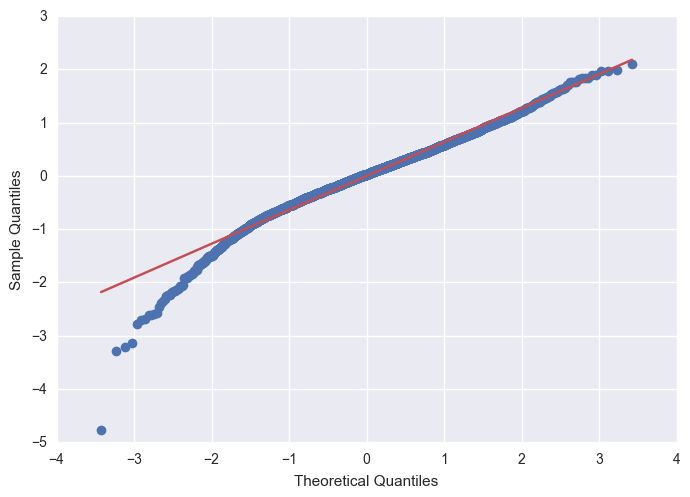

In [43]:
from statsmodels import graphics
Mresid=Mmodel.resid
graphics.gofplots.qqplot(Mresid, line='r')


According to qq plot of model residuals, residuals apparently have a heavy tail. Because movies’ imdb rating score are bounded from 0-10 and we do not use p-value to determine whether factors have significant effect on imdb rating, biased residuals may have limited impact on predicting. Also, our original purpose for building the linear regression model is more to interpret the influence of features than predicting the data, so the nonnormality can be accepted.

__MLR for movies without Metascore__

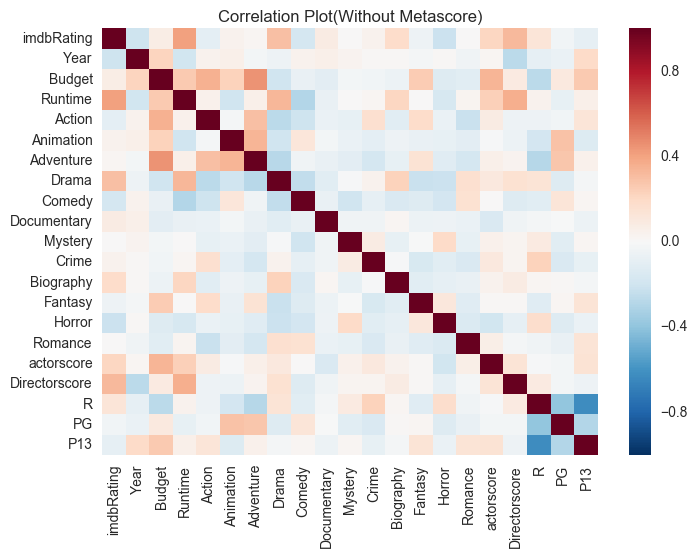

In [45]:
Ncorr=NFinal.corr()
sns.heatmap(Ncorr, 
            xticklabels=Ncorr.columns.values,
            yticklabels=Ncorr.columns.values)
sns.plt.title('Correlation Plot(Without Metascore)')
sns.plt.show()

The correlation between features pretty much stays the same without the Metascore. There is still a observable positive relationship between IMDb rating scores and Runtime, Drama, actorscore, and Director score. Also, there is no apparent multicollinearity shown by this correlation plot.

In [46]:
Nmodel = forward_selected(NFinal, 'imdbRating')
Nmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             imdbRating   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     119.6
Date:                Wed, 22 Mar 2017   Prob (F-statistic):               0.00
Time:                        18:48:07   Log-Likelihood:                -5461.1
No. Observations:                4114   AIC:                         1.096e+04
Df Residuals:                    4096   BIC:                         1.107e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept        26.7813      2.504     10.694      0.000        21.872    31.691
Runtime           0.0124      0.001     13.933      0.000         0.011     0.014
Directorscore     0.4450      0.047      9.540      0.000         0.354     0.536
Drama             0.3669      0.038      9.718      0.000         0.293     0.441
Animation         0.8192      0.078     10.514      0.000         0.666     0.972
Documentary       1.1515      0.108     10.662      0.000         0.940     1.363
actorscore        0.1202      0.015      8.105      0.000         0.091     0.149
Year             -0.0112      0.001     -8.978      0.000        -0.014    -0.009
R                 0.3596      0.042      8.490      0.000         0.277     0.443
Horror           -0.4141      0.055     -7.590      0.000        -0.521    -0.307
Biography         0.2675      0.061      4.382      0.000         0.148     0.387
Action           -0.2319      0.041     -5.690      0.000        -0.312    -0.152
Comedy           -0.1262      0.036     -3.526      0.000        -0.196    -0.056
Budget            0.0009      0.000      1.789      0.074     -8.56e-05     0.002
Fantasy           0.0889      0.043      2.058      0.040         0.004     0.174
Romance          -0.0745      0.041     -1.805      0.071        -0.155     0.006
P13               0.0884      0.045      1.976      0.048         0.001     0.176
Adventure         0.0724      0.045      1.610      0.107        -0.016     0.161
==============================================================================
Omnibus:                      444.457   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.931
Skew:                          -0.745   Prob(JB):                    3.54e-166
Kurtosis:                       4.491   Cond. No.                     3.52e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We are able to interpret the model through the summary of the model. All the interpretations below are based on the assumption that other variables stay __the same__.

For every 1 minute increase of Runtime, IMDb rating score will increase 0.0124 point.

For every 1 year increase of Produced year, IMDb rating score will decrease 0.0112 point.

For every 1 more actor who is listed in top 1000 actors, IMDb rating score will increase 0.1202 point.

The movies directed by directors listed in the TOP250 directors tend to score 0.445 higher than those don't.

Comedy movie tend to score 0.1262 points lower than non comedy movie.

Horror movie tend to score 0.4141 points lower than non Horror movie.

Animation movie tend to score 0.8192 points higher than non Animation movie.

Documentary movie tend to score 1.1515 points higher than non Documentary movie.

Drama movie tend to score 0.3669 points higher than non Drama movie.

Biography movie tend to score 0.2675 points higher than non Biography movie.

Fantasy movie tend to score 0.0889 points higher than non Fantasy movie.

Action movie tend to score 0.2319 points lower than non Action movie.

Adventure movie tend to score 0.0724 points higher than non Adventure movie.

Romance movie tend to score 0.0745 points lower than non Romance movie.

R movies tend to score 0.3596 points higher than unrated movies.

PG-13 movies tend to score 0.0884 points higher than unrated movies.

The summary of the model also provides the Durbin-Watson test score, the score is about 1.802, and since it is between 1.5 and 2.5, there is not autocorrelation present in this model.

In [47]:
test = statsmodels.stats.diagnostic.het_goldfeldquandt(Nmodel.resid, Nmodel.model.exog)
lzip(name, test)

[('F statistic', 1.5612827417130821), ('p-value', 6.4717916790271454e-24)]

We have applied Goldfeld–Quandt test to check the homoscedasticity of the model. With the low p value, it rejects the null hypothesis which is the variances of the errors of the regression model are not constant, so the model satisfy the assumption of homoscedasticity.

In [48]:
print("Mean squared error: %.2f" % Nmodel.mse_resid)
print('Adjusted R square: %.2f' % Nmodel.rsquared_adj)


Mean squared error: 0.84
Adjusted R square: 0.33


Compared to the model included Metascore, the performance of this model is much lower. It is reasonable for the model to behave in this way since Metascore is an influential indicator for the level of IMDb rating scores. This model has still done a fine job, 33 percent of variance in the dependent variable is predictable from the independent variable, and the mean square error is 0.84.

Here we have drawn the qq plot for the residuals of the model to test the normality.

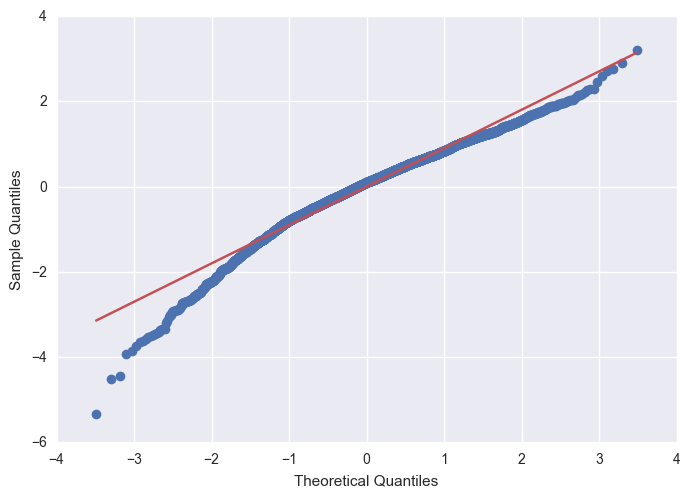

In [49]:
Nresid=Nmodel.resid
graphics.gofplots.qqplot(Nresid, line='r')


According to qq plot of model residuals, residuals have heavy tails in both sides. Because movies’ imdb rating score are bounded and we do not use p-value to determine whether factors have significant effect on imdb rating, biased residuals may have subtle impact on predicting. 


__Random Forest for movies with Metascore__

In [50]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

In [51]:
rf = RandomForestRegressor(n_estimators = 10,max_depth = None)

In [52]:
MY = np.asarray(MFinal['imdbRating'], dtype="float64")
MX = MFinal.drop(['imdbRating'], axis = 1)


In [53]:
rf.fit(MX, MY)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [54]:
y_pred = rf.predict(MX)
y_true = MY
mean_squared_error(y_true, y_pred)

0.082428514426028235

It is common that random forest will perfrom better than MLR on fitting the model, and it is reflected on the far lower MSE. The model tend to overfit when we throw all our data in the train set but nothing left for test set, so I have used 10 fold cross validation to get a more reasonable and less overfitting predictive model and MSE for the random forest model.

In [55]:
from sklearn.cross_validation import KFold
def Cross_Validation(data,X,Y):
    '''
    This function takes the whole dataset, dependent variables data, and independent variables data in
    through this function, we have done a 10 fold cross validation for the model
    and the function will return the average MSE of the random forest model
    '''
    kf = KFold(len(data), n_folds=10)
    x=[]
    for train_index, test_index in kf:
        X_train, X_test = X.ix[train_index,:], X.ix[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        a=mean_squared_error(y_pred, y_test)
        x.append(a)
    return np.mean(x)

In [56]:
Cross_Validation(MFinal,MX,MY)

0.45638820349221332

Through 10 fold cross validation, the MSE increases to about 0.46, which is much higher than before, but more a reasonable amount of mean squared error.

__Random Forest for movies without Metascore__

In [57]:
NY= np.asarray(NFinal['imdbRating'], dtype="float")
NX= NFinal.drop(['imdbRating'], axis = 1)

In [58]:
rf.fit(NX,NY)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [59]:
y_pred = rf.predict(NX)
y_true = NY
mean_squared_error(y_true, y_pred)

0.15699766266947549

It is common that random forest will perfrom better than MLR on fitting the model, and it is reflected on the far lower MSE. The model tend to overfit when we throw all our data in the train set but nothing left for test set, so I have used 10 fold cross validation to get a more reasonable and less overfitting predictive model and MSE for the random forest model. 

In [60]:
Cross_Validation(NFinal,NX,NY)

0.92949130987461837

Through 10 fold cross validation, the MSE increases to about 0.93, which is much higher than before, but more a reasonable amount of mean squared error.

# Conclusion

Through the Data Collecting, Data Munging, Descriptive Analysis, and Predictive Modelling, we have had a comprehensive view on the movie data. We have found out that Metascore, Director, Actor, Runtime, Specific Genres, Rated, and Year play significant roles in deciding the qualities of movies. There is an undoubtly positive relationship between the Metascore and IMDbscore. The more great actors and directors a movie have, the better the movie tends to be. The longer the runtime is, the better the movie is likely to be. Genres such as Biography and Documentary are favored by the audience, and it is hard for the Horror movies to earn viewer's appreciation. People tend to like old movies more, and the movies made for grown-ups tend to be rated higher than those for children to watch. After comprehensively researching on the movie rating scores, there is still room for improvement for our project. Although we have over 4000 movies' data, it is still relatively short on the sample size for predictive modelling. If we can get data of more movies, we will possibly be able to build a better predictive model. Also, the rating scores may be related to the amount of tweets or news which reflect people's expectation on this movie, so these data may help to perfect our model, too.

# Thank you for reading!